This Python notebook contains the code to reproduce the experiments in our [paper](https://arxiv.org/pdf/2101.10040.pdf):
> C. W. Combettes and S. Pokutta. Complexity of linear minimization and projection on some sets. *Operations Research Letters*, 49(4):565&ndash;571, 2021.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.linalg import pinv, svd
from scipy.sparse.linalg import svds
from time import process_time

In [ ]:
def plotter(n_grid, lp, qp, title=None, xticks=False):
        
    fig = plt.figure()
    fig.set_figheight(3)
    fig.set_figwidth(3.5)
    
    lp_mean, lp_std = np.mean(lp, axis=1), np.std(lp, axis=1)
    qp_mean, qp_std = np.mean(qp, axis=1), np.std(qp, axis=1)
    
    plt.plot(n_grid, qp_mean, 'o-', color='tab:blue', label='projection')
    plt.fill_between(n_grid, qp_mean+qp_std, qp_mean-qp_std, color='tab:blue', alpha=0.2)
    plt.plot(n_grid, lp_mean, 'o-', color='tab:orange', label='linear\nminimization')
    plt.fill_between(n_grid, lp_mean+lp_std, lp_mean-lp_std, color='tab:orange', alpha=0.2)
    
    plt.yscale('log')
    plt.xscale('log')
    
    if title:
        plt.title(title)
    plt.ylabel('CPU time (s)')
    plt.xlabel('Dimension $n$')
    plt.legend()
    
    plt.grid(linestyle=':')
    if xticks:
        plt.xticks(xticks[0], xticks[1])
    plt.tick_params(which='minor', left=False, bottom=False)

    plt.show()

# Projection onto the standard simplex

This function is used for Figures 1 and 2.

In [ ]:
def proj_simplex(y):
    
    '''
    Projection onto the standard simplex
    The input y must be in the nonnegative orthant
    '''
    
    if np.sum(y) == 1:
        return y
    
    v, vv, rho = [y[0]], [], y[0]-1
    N = len(y)

    for n in range(1, N):
        yn = y[n]
        if yn > rho:
            rho += (yn-rho)/(len(v)+1)
            if rho > yn-1:
                v.append(yn)
            else:
                vv.extend(v)
                v = [yn]
                rho = yn-1

    if len(vv) > 0:
        for w in vv:
            if w > rho:
                v.append(w)
                rho += (w-rho)/len(v)

    l, flag = len(v), 1
    while flag == 1:
        for w in v:
            if w <= rho:
                v.remove(w)
                rho += (rho-w)/len(v)
        if len(v) != l:
            l, flag = len(v), 1
        else:
            flag = 0

    return np.maximum(y-rho, 0)

# Figure 1: The $\ell_1$-ball

In [ ]:
def LP(y):
    
    idx = np.argmax(np.abs(y))
    x = np.zeros(len(y))
    x[idx] = -np.sign(y[idx])
        
    return x

def QP(y):
    
    if np.linalg.norm(y, 1) <= 1:
        return y
    
    else:
        return np.sign(y)*proj_simplex(np.abs(y))

In [ ]:
n_grid = [10**i for i in range(2, 9)]

lp, qp = [], []

for n in n_grid:

    print(n)
    
    lpn, qpn = [], []
    
    for k in range(5):
        
        y = np.random.randn(n)

        t1 = process_time()
        LP(y)
        t2 = process_time()
        QP(y)
        t3 = process_time()

        lpn.append(t2-t1)
        qpn.append(t3-t2)

    lp.append(lpn)
    qp.append(qpn)

100
1000
10000
100000
1000000
10000000
100000000


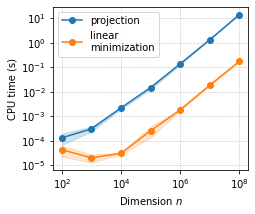

In [ ]:
plotter(n_grid, lp, qp, xticks=[[10**(2*i) for i in range(1, 5)], ['$10^{}$'.format(2*i) for i in range(1, 5)]])

# Figure 2: The nuclear norm-ball

In [ ]:
def LP(Y, solver):
    
    u, s, vt = svds(-Y, k=1, which='LM', solver=solver)
    
    return np.outer(u, vt)

def QP(Y):
    
    u, s, vh = np.linalg.svd(Y, full_matrices=False)
    ss = proj_simplex(s)
    
    return np.dot(u, ss*vh)

In [ ]:
n_grid = [100, 200, 500, 1000, 2000, 5000, 10000]

## Left: Random input

In [ ]:
lp, qp = [], []

for n in n_grid:

    print(n)
    
    lpn, qpn = [], []
    
    for k in range(5):
        
        Y = np.random.randn(n, n)

        t1 = process_time()
        LP(Y, 'arpack')
        t2 = process_time()
        QP(Y)
        t3 = process_time()

        lpn.append(t2-t1)
        qpn.append(t3-t2)

    lp.append(lpn)
    qp.append(qpn)

100
200
500
1000
2000
5000
10000


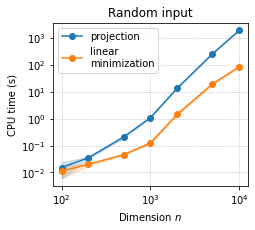

In [ ]:
plotter(n_grid, lp, qp, title='Random input')

## Right: Random symmetric input

In [ ]:
lp, qp = [], []

for n in n_grid:

    print(n)
    
    lpn, qpn = [], []
    
    for k in range(5):
        
        Y = np.random.randn(n, n)
        Y = (Y+np.transpose(Y))/2

        t1 = process_time()
        LP(Y, 'lobpcg')
        t2 = process_time()
        QP(Y)
        t3 = process_time()

        lpn.append(t2-t1)
        qpn.append(t3-t2)

    lp.append(lpn)
    qp.append(qpn)

100
200
500
1000
2000
5000
10000


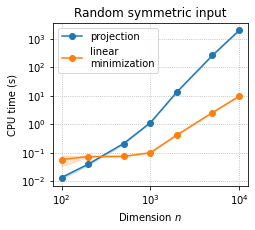

In [ ]:
plotter(n_grid, lp, qp, title='Random symmetric input')

# Bonus: The Birkhoff polytope

Checking the expressions of $A^\dagger$ and $A^\dagger A$ numerically.

In [ ]:
def a(n):

    A = np.zeros((2*n, n**2))
    A[n:] = np.concatenate([np.identity(n)]*n, axis=1)

    e = np.ones(n)
    for i in range(n):
        A[i, n*i:n*(i+1)] = e
        
    return A

def adag(n):
    
    return np.transpose(a(n))/n-np.ones((n**2, 2*n))/(2*n**2)

def adaga(n):
    
    I, J = np.identity(n), np.ones((n, n))
    
    B1 = n*I+(n-1)*J
    B2 = n*I-J
    
    return np.block([[B2]*i+[B1]+[B2]*(n-1-i) for i in range(n)])/n**2

In [ ]:
n = 4

print(a(n), '\n')
print(adaga(n)*n**2)

[[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.]] 

[[ 7.  3.  3.  3.  3. -1. -1. -1.  3. -1. -1. -1.  3. -1. -1. -1.]
 [ 3.  7.  3.  3. -1.  3. -1. -1. -1.  3. -1. -1. -1.  3. -1. -1.]
 [ 3.  3.  7.  3. -1. -1.  3. -1. -1. -1.  3. -1. -1. -1.  3. -1.]
 [ 3.  3.  3.  7. -1. -1. -1.  3. -1. -1. -1.  3. -1. -1. -1.  3.]
 [ 3. -1. -1. -1.  7.  3.  3.  3.  3. -1. -1. -1.  3. -1. -1. -1.]
 [-1.  3. -1. -1.  3.  7.  3.  3. -1.  3. -1. -1. -1.  3. -1. -1.]
 [-1. -1.  3. -1.  3.  3.  7.  3. -1. -1.  3. -1. -1. -1.  3. -1.]
 [-1. -1. -1.  3.  3.  3.  3.  7. -1. -1. -1.  3. -1. -1. -1.  3.]
 [ 3. -1. -1. -1.  3. -1. -1. -1.  7.  3.  3.  3.  3.

In [ ]:
n = np.random.randint(2, 50)
print('n =', n, '\n')

A = a(n)

Adag = pinv(A)
print(np.linalg.norm(adag(n)-Adag)/np.linalg.norm(Adag))

AdagA = np.dot(Adag, A)
print(np.linalg.norm(adaga(n)-AdagA)/np.linalg.norm(AdagA))

n = 41 

2.0780951612058536e-15
2.0157965083325153e-15
